# CUNEF
### Trabajo de Final de Master 

# 02. Recoleccion de datos Espaciales y Pre-Procesado dedatos temporales y espaciales

In [3]:
# Importamos las librerias que van a ser utilizados
import pandas as pd
import numpy as np
import seaborn as sns

from scipy.spatial.distance import squareform, pdist

import numpy as np

import pickle

In [4]:
# Funcion definida para separar la parte de train de la parte de test de los datos
def train_test_split(data, train_portion,window):
    y_pred_2=data.iloc[:,-1] #Seleccionamos el ultimo valor para utilizarlo como test
    time_len = data.shape[1]
    # Estos dos pasos son para eliminar el ultimo valor seleccionado reservado para la predicción
    indice_ultima_fila = data.columns[-1]
    data=data.drop(indice_ultima_fila,axis=1)

    train_size = int(time_len * train_portion)
    train_data = np.array(data.iloc[:,:train_size])
    val_data = np.array(data.iloc[:, train_size:-window])
    test_data=np.array(data.iloc[:, -window:])
    return train_data,val_data, test_data, y_pred_2

# Funcion definida para el escalado de los datos de una serie temporal
def scale_data(train_data, val_data, test_data, pred_data):
    max_speed = train_data.max()
    min_speed = train_data.min()
    train_scaled = (train_data - min_speed) / (max_speed - min_speed)
    test_scaled = (test_data - min_speed) / (max_speed - min_speed)
    pred_scaled=(pred_data - min_speed) / (max_speed - min_speed)
    val_scaled=(val_data - min_speed) / (max_speed - min_speed)
    return train_scaled,val_scaled, test_scaled, pred_scaled

# Funcion definida para realizar la ventana de los datos con los que se van a trabajar
def sequence_data_preparation(seq_len, pre_len, train_data, val_data, test_data):
    trainX, trainY, valX, valY, testX, testY = [], [], [], [], [], []

    for i in range(train_data.shape[1] - int(seq_len + pre_len - 1)):
        a = train_data[:, i : i + seq_len + pre_len]
        trainX.append(a[:, :seq_len])
        trainY.append(a[:, -1])
    
    
    for i in range(val_data.shape[1] - int(seq_len + pre_len - 1)):
        b = val_data[:, i : i + seq_len + pre_len]
        valX.append(b[:, :seq_len])
        valY.append(b[:, -1])


    for i in range(test_data.shape[1] - int(seq_len + pre_len - 1)):
        b = test_data[:, i : i + seq_len + pre_len]
        testX.append(b[:, :seq_len])
        testY.append(b[:, -1])

    trainX = np.array(trainX)
    trainY = np.array(trainY)
    valX = np.array(valX)
    valY = np.array(valY)
    testX = np.array(testX)
    testY = np.array(testY)

    return trainX, trainY, valX, valY, testX, testY

# Datos Espaciales

### 1. Importar los datos a trabajar

**1.1 Importamos los datos con los que vamos a trabajar**

In [5]:
# Importamos los datos de los sensores seleccionados en la muestra
df_sensor=pd.read_excel("../datos/02_localizacion/pmed_ubicacion_12-2022.xlsx")

# Seleccionamos los sensores con los que queremos trabajar
df_sensor=df_sensor.loc[:,['id','longitud','latitud']]
print(df_sensor.shape)
df_sensor.head(10)

(4690, 3)


,id,longitud,latitud
0,3840,-3.688323,40.430502
1,3841,-3.687256,40.430524
2,3842,-3.691727,40.422132
3,3843,-3.691929,40.421433
4,3844,-3.688470,40.433782
5,3845,-3.690991,40.423512
6,3846,-3.698403,40.428164
7,3847,-3.694556,40.428791
8,3848,-3.694187,40.426925
9,3849,-3.696561,40.426881


**1.2 Seleccionamos los datos midentificados en Tableau**\
Hacemos una seleccion de los sensores que fueron seleccionados en Tableau con los que vamos a trabajar

In [6]:
#Descargamos los sensores con los que vamos a trabajar con la eleccion realizada en Tableau
sensores_tableau=pd.read_excel("../datos/03_procesados/sensores_seleccion_tableau.xlsx", header = 1)
sensores_tableau=sensores_tableau.loc[:,'Id']

# Creamos una columna para identificar cuales fueron los sensores seleccionados
df_sensor['sensor_select']=df_sensor['id'].isin(sensores_tableau)

# Filtramos a solo los sensores que se encuentran como True
df_sensor=df_sensor[df_sensor['sensor_select']==True].drop('sensor_select', axis=1)
df_sensor

,id,longitud,latitud
2,3842,-3.691727,40.422132
3,3843,-3.691929,40.421433
4,3844,-3.688470,40.433782
5,3845,-3.690991,40.423512
6,3846,-3.698403,40.428164
...,...,...,...
4337,4050,-3.669007,40.419623
4338,4049,-3.668998,40.422817
4339,4056,-3.670575,40.421251
4340,4051,-3.667429,40.420890


### 2. Creamos la matriz de distancia y normalizamos datos

In [34]:
matrix_lat_long=pd.DataFrame(squareform(pdist(df_sensor.iloc[:, 1:])), 
             columns=df_sensor.id.unique(), 
             index=df_sensor.id.unique())

matrix_lat_long.iloc[:10,:10]

,3842,3843,3844,3845,3846,3847,3849,7029,10034,3851
3842,0.000000,0.000727,0.012097,0.001564,0.008998,0.007235,0.006777,0.002293,0.001242,0.005470
3843,0.000727,0.000000,0.012824,0.002281,0.009339,0.007812,0.007151,0.003014,0.001906,0.006197
3844,0.012097,0.012824,0.000000,0.010575,0.011412,0.007872,0.010634,0.009837,0.011037,0.006644
3845,0.001564,0.002281,0.010575,0.000000,0.008751,0.006370,0.006510,0.000739,0.001056,0.003934
3846,0.008998,0.009339,0.011412,0.008751,0.000000,0.003898,0.002245,0.008583,0.007993,0.008499
3847,0.007235,0.007812,0.007872,0.006370,0.003898,0.000000,0.002768,0.005929,0.006010,0.004842
3849,0.006777,0.007151,0.010634,0.006510,0.002245,0.002768,0.000000,0.006364,0.005751,0.006627
7029,0.002293,0.003014,0.009837,0.000739,0.008583,0.005929,0.006364,0.000000,0.001533,0.003195
10034,0.001242,0.001906,0.011037,0.001056,0.007993,0.006010,0.005751,0.001533,0.000000,0.004483
3851,0.005470,0.006197,0.006644,0.003934,0.008499,0.004842,0.006627,0.003195,0.004483,0.000000


In [35]:
# Se divide toda la matriz entre 1 para poder tener la longitud de los datos mas lejanos con menor peso que los mas cercanos
matrix_lat_long= matrix_lat_long.apply(lambda x: 1/x)

# A la diagonal se le resta infinito para poder tener Nan por valor
matrix_lat_long=matrix_lat_long-np.diag(np.diag(matrix_lat_long))

# Todos los Nan que estan en la diagonal principal seran cambiados con 0
matrix_lat_long=matrix_lat_long.fillna(0)

# Verificamos la matriz realizada
matrix_lat_long=matrix_lat_long.round(2)
matrix_lat_long.head(10)

,3842,3843,3844,3845,3846,3847,3849,7029,10034,3851,...,4684,5762,5763,5765,5766,4050,4049,4056,4051,4059
3842,0.00,1374.87,82.67,639.41,111.14,138.22,147.56,436.19,804.98,182.81,...,41.64,41.30,42.10,40.18,39.97,43.75,43.98,47.24,41.10,43.26
3843,1374.87,0.00,77.98,438.50,107.08,128.00,139.84,331.77,524.75,161.38,...,40.78,40.24,41.00,39.21,39.03,43.49,43.53,46.83,40.81,42.77
3844,82.67,77.98,0.00,94.56,87.62,127.04,94.03,101.66,90.61,150.52,...,55.44,66.39,68.51,62.01,60.30,41.55,44.75,45.78,40.53,45.07
3845,639.41,438.50,94.56,0.00,114.28,157.00,153.62,1353.82,946.97,254.22,...,43.98,43.99,44.91,42.69,42.41,44.79,45.45,48.68,42.18,44.79
3846,111.14,107.08,87.62,114.28,0.00,256.57,445.53,116.51,125.11,117.66,...,35.19,37.90,38.58,36.51,36.00,32.67,33.46,34.88,31.43,33.27
3847,138.22,128.00,127.04,157.00,256.57,0.00,361.22,168.67,166.39,206.51,...,40.78,44.16,45.10,42.35,41.71,36.84,38.10,39.78,35.39,37.92
3849,147.56,139.84,94.03,153.62,445.53,361.22,0.00,157.13,173.88,150.90,...,37.20,39.51,40.27,38.10,37.62,35.09,35.89,37.61,33.62,35.63
7029,436.19,331.77,101.66,1353.82,116.51,168.67,157.13,0.00,652.37,312.98,...,44.94,45.25,46.22,43.83,43.52,44.94,45.81,48.97,42.40,45.21
10034,804.98,524.75,90.61,946.97,125.11,166.39,173.88,652.37,0.00,223.07,...,42.09,42.33,43.19,41.08,40.80,42.88,43.40,46.39,40.45,42.79
3851,182.81,161.38,150.52,254.22,117.66,206.51,150.90,312.98,223.07,0.00,...,49.04,51.29,52.56,49.25,48.67,44.83,46.68,49.27,42.71,46.36


<Axes: >

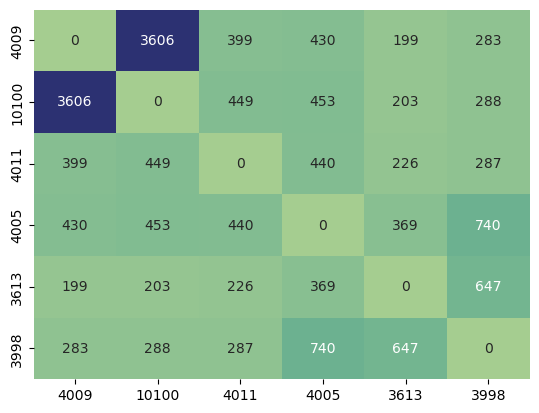

In [38]:
Sensores=['4009','10100','4011','4005','3613','3998']

matrix_test=matrix_lat_long.copy()
matrix_test=matrix_test.loc[[4009,10100,4011,4005,3613,3998],[4009,10100,4011,4005,3613,3998]]
sns.heatmap(matrix_test,vmin=0,cmap="crest",fmt='.0f',annot=True, cbar=False)

In [10]:
# Guardamos nuestro dataset como pickle
pickle.dump(matrix_lat_long, open('../datos/04_pickles/matrix_lat_long_final', 'wb'))

# Datos Temporales

### 1. Importar los datos a temporales trabajados previamente

In [11]:
speed_data=pd.read_csv("../datos/03_procesados/datos_procesados.csv", index_col='id')
speed_data

,0,1,2,3,4,5,6,7,8,9,...,11750,11751,11752,11753,11754,11755,11756,11757,11758,11759
id,,,,,,,,,,,,,,,,,,,,,
3396,317.0,328.0,257.0,248.0,271.0,300.0,167.0,216.0,161.0,180.0,...,323.0,394.0,487.0,592.0,566.0,359.0,212.0,177.0,145.0,183.0
3397,551.0,512.0,444.0,420.0,352.0,308.0,272.0,300.0,319.0,248.0,...,495.0,604.0,727.0,912.0,645.0,534.0,371.0,215.0,141.0,161.0
3407,711.0,535.0,681.0,621.0,564.0,518.0,561.0,438.0,355.0,384.0,...,403.0,380.0,433.0,591.0,530.0,510.0,328.0,242.0,232.0,270.0
3435,1297.0,1359.0,1243.0,1119.0,933.0,897.0,893.0,660.0,616.0,524.0,...,1230.0,1402.0,1462.0,2022.0,1638.0,1112.0,598.0,320.0,317.0,265.0
3465,1226.0,1128.0,908.0,776.0,649.0,444.0,486.0,380.0,318.0,318.0,...,340.0,90.0,90.0,637.0,819.0,745.0,448.0,297.0,330.0,376.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10874,1072.0,1007.0,1017.0,920.0,728.0,670.0,597.0,524.0,518.0,444.0,...,1061.0,875.0,972.0,1124.0,820.0,613.0,629.0,534.0,498.0,368.0
10878,741.0,578.0,528.0,392.0,390.0,271.0,299.0,254.0,307.0,216.0,...,644.0,852.0,940.0,909.0,840.0,504.0,303.0,240.0,239.0,257.0
10883,241.0,264.0,212.0,156.0,140.0,126.0,88.0,51.0,93.0,81.0,...,180.0,104.0,160.0,248.0,176.0,144.0,122.0,92.0,83.0,100.0


In [12]:
num_nodes, time_len = speed_data.shape
print("No. of sensors:", num_nodes, "\nNo of timesteps:", time_len)

No. of sensors: 313 
No of timesteps: 11760


### 2. Separamos los datos de train y test

Definimos la proporción de los datos que van a ser tomados para el datasest de training y separamos el dataset de entrenamiento del dataset de test. Como vamos a utilizar la técnica de Sliding Window no tomamos valores de validación solo dejamos la ultima ventana como test

In [13]:
# Seleccionamos la proporcion de muestra de entrenamiento
train_size = 0.8
test_values = 11 #numero de valores que vamos a dejar para el dataset de validación

# Separamos ambos dataset com la función que fue definida 
train_data, val_data, test_data, pred_2 = train_test_split(speed_data,train_size, test_values)

# Verificamos como fueron separados los datos
print("Train data: ", train_data.shape)
print("Val data: ", val_data.shape)
print("Test data: ", test_data.shape)
print( pred_2.shape)

Train data:  (313, 9408)
Val data:  (313, 2340)
Test data:  (313, 11)
(313,)


### 3. Escalamos los datos de series temporales

Con la funcion creada y definida al inicio de este notebook se van a dividir todos los valores del dataset de entrenamiento y de test con los valores de maximo y minimo del dataset de entrenamiento. Fue tomada está opcion y no un escalado con una función previamente creada en sikit learn para asegurar la consistencia de los datos y así evitar sesgos en la parte de preprocesado de datos

In [14]:
# Escalado de variables para normalizado
train_scaled,val_scaled, test_scaled, pred_2 = scale_data(train_data, val_data, test_data, pred_2)

# Verificamos los valores maximos y minimos de los dataset preprocesados
print(f'El valor maximo del dataset de entrenamiento es de {train_scaled.max()}, y el valor minimo del dataset es de {train_scaled.min()}')
print(f'El valor maximo del dataset de entrenamiento es de {val_scaled.max()}, y el valor minimo del dataset es de {val_scaled.min()}')
print(f'El valor maximo del dataset de test es de {round(test_scaled.max(),2)}, y el valor minimo del dataset es de {test_scaled.min()}')

El valor maximo del dataset de entrenamiento es de 1.0, y el valor minimo del dataset es de 0.0
El valor maximo del dataset de entrenamiento es de 0.7719085394307046, y el valor minimo del dataset es de 0.0
El valor maximo del dataset de test es de 0.43, y el valor minimo del dataset es de 0.0


### 4. Creamos la ventana de datos con los que vamos a trabajar

In [15]:
# Definimos el rango de valores que vamos a producir
seq_len = 2*5 #se tomaran 10 valores que sería un timelapse de 5 horas
pre_len = 1 #la ventana que se evaluará será de 60 min a predecir

In [16]:
# Aqui lo que se realiza es que se recorren los datos como el sliding windows
trainX, trainY, valX, valY, testX, testY = sequence_data_preparation(
    seq_len, pre_len, train_scaled, val_scaled, test_scaled
)

print(trainX.shape)
print(trainY.shape)
print(valX.shape)
print(valY.shape)
print(testX.shape)
print(testY.shape)
print(pred_2.shape)

(9398, 313, 10)
(9398, 313)
(2330, 313, 10)
(2330, 313)
(1, 313, 10)
(1, 313)
(313,)


In [17]:
#Exportamos los distintos dataset creados para poder ser utilizados en el modelo
np.save('../datos/03_procesados/trainX',trainX)
np.save('../datos/03_procesados/trainY',trainY)
np.save('../datos/03_procesados/valX',valX)
np.save('../datos/03_procesados/valY',valY)
np.save('../datos/03_procesados/testX',testX)
np.save('../datos/03_procesados/testY',testY)
np.save('../datos/03_procesados/pred_11',pred_2)


np.save('../datos/03_procesados/test_scaled',test_scaled)
np.save('../datos/03_procesados/train_scaled',train_scaled)

np.save('../datos/03_procesados/train_data',train_data)